# Satellite images segmentation

The task consists of creating a neural model able to perform semantic segmentation on satellite images into six (seven with the no information) different classes. The data used in this project is extracted from the [IGN](https://geoservices.ign.fr/telechargement) archives, and can be downloaded [here](https://drive.google.com/file/d/1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem/view?usp=sharing).

Each tile in the dataset has a 1000x1000 resolution representing a 500m x 500m footprint (the resolution is 50cm per pixel).

The file structure of the dataset is as follows:
```none
├── ign
│   ├── annotations
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png
│   ├── images
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png

```

Here is an example of the image/mask contained in the dataset: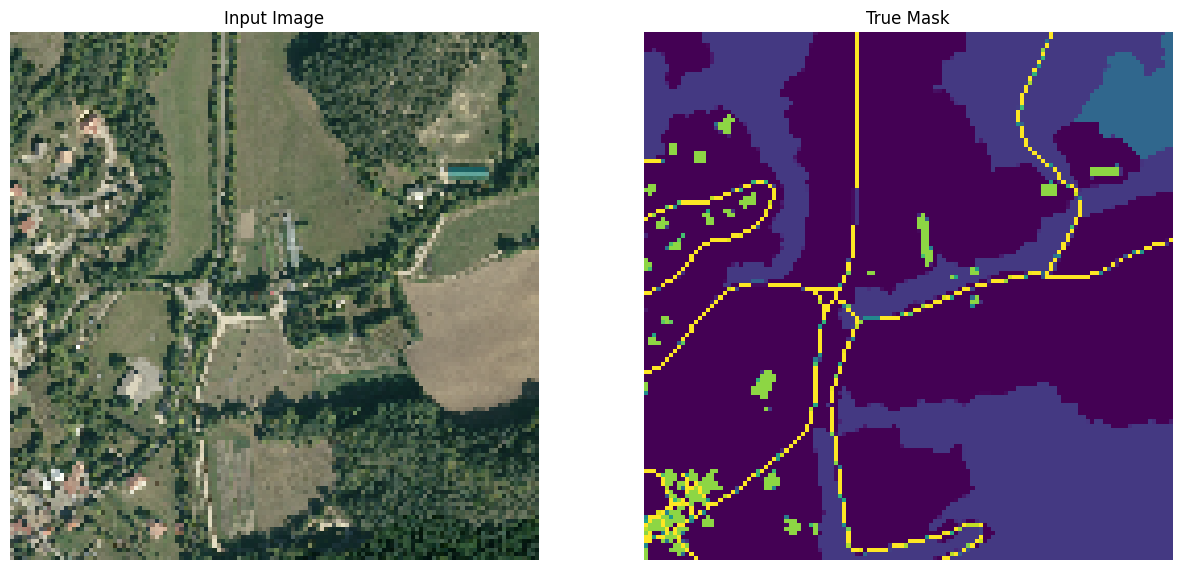

HINT: If the data does not fit into the memory, try by patching the image into smaller portions.

## Downloading the data

The data can be either downloaded from the link above and uploaded directly on Colab, or by running the following code snippet, that automatically downloads the data and unzip it.

In [ ]:
!gdown 1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem
!unzip ign_dataset.zip
!rm ign_dataset.zip

## Multi-class segmentation

In this project, the input-target pair is composed by a $1000 \times 1000$ RGB image as visualized above, together with a $1000 \times 1000$ mask, that classifies each pixel by assigning to it a real number.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob

X_path = './ign/images/'
Y_path = './ign/annotations/'

train_name = sorted(os.listdir(os.path.join(X_path, 'training')))
test_name = sorted(os.listdir(os.path.join(X_path, 'validation')))

# As an example: load a sample to check the data
x_sample = plt.imread(os.path.join(X_path, 'training', train_name[10]))
y_sample = plt.imread(os.path.join(Y_path, 'training', train_name[10]))

print(f"Shape of x: {x_sample.shape}. Shape of y: {y_sample.shape}.")
print(f"Unique values of y: {np.unique(y_sample)}.")

Shape of x: (1000, 1000, 3). Shape of y: (1000, 1000).
Unique values of y: [0.         0.00392157 0.02352941].


In the example above, $\texttt{y_sample}$ contains 3 classes, represented by the three unique real numbers $[0, 0.00392157, 0.02352941]$.

Note that this approach is unusual in multiclass segmentation, where usually the mask is reshaped to be an $height \times width \times num. class$ binary array, where the pixel in position $(i, j)$ is classified as the class associated to the value 1, among the channels.

In this project, we assume that your data is processed as described above, since the metric used for the evaluation is implemented this way.  

## Metrics
The comparison metric for this project is the Dice Cofficient for multi-class segmentation (see the Lab about Segmentation for more informations). To apply this function, you are required to reshape both the predicted mask and the true mask to shape $\texttt{(batch_size, h, w, num_classes)}$, where $\texttt{num_classes}$ is the number of segmentation classes.

**IMPORTANT**: Remember to leave a print of average Dice Coefficient among the test set on the Notebook for a comparison. To do that, just measure the Dice Coffient by using the functions below for each batch, and take the average.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

## Project implementation

Good luck!

## Data Preprocessing

To start with, we load the training set (images and masks). To keep the spatial context of the satellite maps intact, we resize the images to 128x128. This way, we can train our model without saturating the memory. Moreover, we do not need to normalize the data since the images are already in range 0-1.

In previous experiments, I tried a combination of resize and patching, i.e., I first resized the images to 500x500 and took two random 128x128 subpatches. Experiments showed that the first approach (resize only) let the model generalize better. The intuition is that the model has a more global understanding of the region, even if not in highest details, instead of a too zoomed version of the map. Moreover, the implemented architecture is perfectly able to detect features at different scales.

In [ ]:
import cv2

# We have 6(+1) total classes
labels = {
    0: 'Unlabeled',
    1: 'Dense forest',
    2: 'Sparse forest',
    3: 'Moor',
    4: 'Herbaceous formation',
    5: 'Building',
    6: 'Road'
}

ORIGINAL_SIZE = 1000
MID_SIZE = 500    # Used for previous experiments
PATCH_SIZE = 128
N_CLASSES = 7     # Number of classes for segmentation
N_TRAIN = 600     # Number of train images
N_TEST = 200      # Number of test images

In [ ]:
# Capture training images in a list
train_images = []
train_masks = []

for i in range(N_TRAIN):
  # read image and mask (1000,1000,3)
  img = plt.imread(os.path.join(X_path, 'training', train_name[i]))
  mask = plt.imread(os.path.join(Y_path, 'training', train_name[i]))

  # We resize to 128x128
  img = cv2.resize(img, (PATCH_SIZE, PATCH_SIZE))
  mask = cv2.resize(mask, (PATCH_SIZE, PATCH_SIZE), interpolation = cv2.INTER_NEAREST)
  # We wish to keep the ground thruth intact and not interpolate

  # append selected region
  train_images.append(img)
  train_masks.append(mask)

  '''
  # We resize to 500x500 and take (two) 128x128 subpatches
  # resize (500,500,3)
  img = cv2.resize(img, (MID_SIZE, MID_SIZE))
  mask = cv2.resize(mask, (MID_SIZE, MID_SIZE), interpolation = cv2.INTER_NEAREST)
  # We wish to keep the ground thruth intact and not interpolate

  for j in range(2):
    # pick random patches
    x, y = np.random.randint(MID_SIZE-PATCH_SIZE, size=2)

    # append selected region
    train_images.append(img[x:x+PATCH_SIZE, y:y+PATCH_SIZE])
    train_masks.append(mask[x:x+PATCH_SIZE, y:y+PATCH_SIZE])
  '''

# Convert list to numpy array
train_images = np.array(train_images)
train_masks = np.array(train_masks)
print(f'train images: {train_images.shape}')
print(f'train masks: {train_masks.shape}')

x_train = train_images

train images: (600, 128, 128, 3)
train masks: (600, 128, 128)


Since the classes in the masks are annotated as real numbers, we encode them in integers from 0 to 6. This operation is crucial for the following step (one-hot encoding). To achieve this mapping we use the utility `LabelEncoder` from `sklearn.preprocessing`.

In [ ]:
# We encode the classes from reals to 0-6 integers
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape # (600, 128, 128)

train_masks = np.ravel(train_masks)
train_masks = labelencoder.fit_transform(train_masks)
train_masks = train_masks.reshape(n, h, w)

print(f'New encoding: {np.unique(train_masks)}')
print(f'train masks: {train_masks.shape}')

New encoding: [0 1 2 3 4 5 6]
train masks: (600, 128, 128)


We one-hot encode the masks. From one-channel integer masks we get their binary representation, where on the channel dimension we have the number of classes (7). We expect to have 1 in channel `k` if the pixel at `(i,j)` is of class `k`; 0 if it belongs to another class.

In [ ]:
# We expand the dimension of the masks and one-hot encode
# We get 7 channels, each corresponding to its label
from keras.utils import to_categorical

train_masks = np.expand_dims(train_masks, axis=3)
y_train = to_categorical(train_masks, num_classes=N_CLASSES)
print(f'y_train: {y_train.shape}')

y_train: (600, 128, 128, 7)


We then take a quick look at the images and their annotations. To visualize the masks, we need to plot them layer by layer, each corresponding to their class.

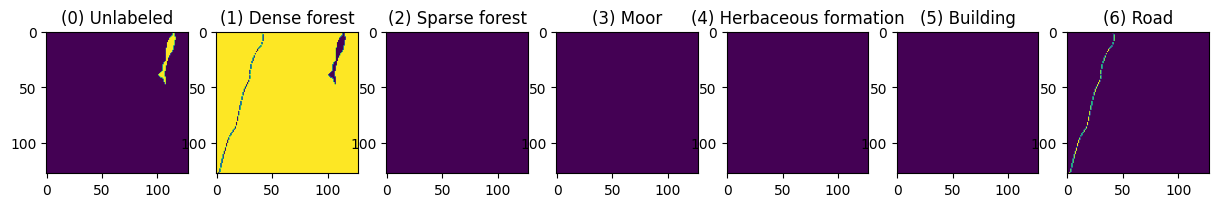

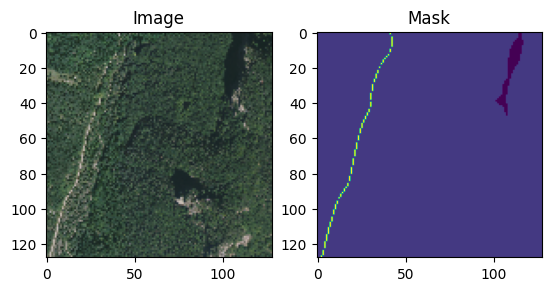

In [ ]:
# Let's inspect some random masks
#N_TRAIN = len(y_train)
n = np.random.randint(N_TRAIN)
plt.figure(figsize=(15,5))
for i in range(N_CLASSES):
  plt.subplot(1, N_CLASSES, i+1)
  plt.title(f'({i}) {labels[i]}')
  plt.imshow(y_train[n,:,:,i], vmin=0., vmax=1.)
plt.show()

# Visualize the image and "overlapping" mask
plt.subplot(1,2,1)
plt.title('Image')
plt.imshow(x_train[n], vmin=0., vmax=1.)
plt.subplot(1,2,2)
plt.title('Mask')
plt.imshow(train_masks[n], vmin=0, vmax=6)


We then check if the dataset is balanced or not, i.e., we have predominance of some classes over the others. Indeed, we notice that most of the segments fall in the `(1) Dense Forest` category, whereas in `(5) Building` class we have relatively small amount of samples. On top of that, we notice that samples in `(6) Road` class are sometimes difficult to spot even to human eye. This is because they are hidden by trees or invisible to distisguish from the background.

Using the useful utility `class_weight` from `sklearn`, we can assign more or less weight to the given classes based on their frequences in the dataset. In other words, a class with a lot of samples gets low weight and viceversa. The process of assigning weights will be crucial during the training, where we guide the learning towards difficult segments to classify.

In [ ]:
# We can that the dataset is unbalanced
# Class 1 (Dense forest) is very popular, and has low weight
# Class 5 (Building) is very rare, and we put more weight

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(np.ravel(train_masks)),
    y = np.ravel(train_masks))

'''
class_weights_dict = {}
for i, w in enumerate(class_weights):
  class_weights_dict[i] = float(w)
'''
print(class_weights)

[ 1.25017614  0.23226675  1.22851637  2.07075545  2.07220377 93.46085832
  9.56617274]


We now repeat the same process, but for test data. As we did before, due to high resolution images and to preserve spatial context, we resize the images to 128x128 patches.

We will end up with:
- `x_test` of shape (200,128,128,3)
- `y_test` of shape (200,128,128,7)

In [ ]:
# Capture testing images in a list
test_images = []
test_masks = []

for i in range(N_TEST):
  # read image and mask (1000,1000,3)
  img = plt.imread(os.path.join(X_path, 'validation', test_name[i]))
  mask = plt.imread(os.path.join(Y_path, 'validation', test_name[i]))

  # We resize to 128x128
  img = cv2.resize(img, (PATCH_SIZE, PATCH_SIZE))
  mask = cv2.resize(mask, (PATCH_SIZE, PATCH_SIZE), interpolation = cv2.INTER_NEAREST)
  # We wish to keep the ground thruth intact and not interpolate

  # append selected region
  test_images.append(img)
  test_masks.append(mask)

  ''' This is the resize+subpatch method
  # resize (500,500,3)
  img = cv2.resize(img, (MID_SIZE, MID_SIZE))
  mask = cv2.resize(mask, (MID_SIZE, MID_SIZE), interpolation = cv2.INTER_NEAREST)
  # We wish to keep the ground thruth intact and not interpolate

  # pick random patches
  x, y = np.random.randint(MID_SIZE-PATCH_SIZE, size=2)

  # append selected region
  test_images.append(img[x:x+PATCH_SIZE, y:y+PATCH_SIZE])
  test_masks.append(mask[x:x+PATCH_SIZE, y:y+PATCH_SIZE])
  '''

# Convert list to numpy array
test_images = np.array(test_images)
test_masks = np.array(test_masks)
print(f'test images: {test_images.shape}')
print(f'test masks: {test_masks.shape}')

x_test = test_images

test images: (200, 128, 128, 3)
test masks: (200, 128, 128)


In [ ]:
# We encode the classes from reals to 0-6 integers
labelencoder = LabelEncoder()
n, h, w = test_masks.shape # (200, 128, 128)

test_masks = np.ravel(test_masks)
test_masks = labelencoder.fit_transform(test_masks)
test_masks = test_masks.reshape(n, h, w)

print(f'New encoding: {np.unique(test_masks)}')
print(f'test masks: {test_masks.shape}')

New encoding: [0 1 2 3 4 5 6]
test masks: (200, 128, 128)


In [ ]:
# And now we hot-encode
test_masks = np.expand_dims(test_masks, axis=3)
y_test = to_categorical(test_masks, num_classes=N_CLASSES)

print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

x_test: (200, 128, 128, 3)
y_test: (200, 128, 128, 7)


## The Model: MultiResUNet
This is an enhanced version of the UNet, initially deployed to perform Biomedical Binary Image Segmentation. As described below, the architecture is overall similar to the standard UNet, both in term of structure and number of parameters, but differs in some aspects. We adapt the architecture as described in the original paper to our multi-segmentation case, where we have 7 classes instead of 2.

**Description**

MultiResUnet is mainly based on the standard UNet architecture, where we have the two well-known feature extractors working together: the Encoder and Decoder. The Encoder (contraction phase) takes the original image as input and progressively extract features, increasing the number of channels and reducing the spatial dimension. The process is repeated several time (4-5). Then, the Decoder (expansion phase) takes the activations in this latent space and gradually upsamples them, halfing the channel dimension. On top of that, features extracted from the contraction phase are concatenated with these new activations.

**Differences from the standard UNet**

As stated in the original paper, two novel modules were introduced to potentially increase the model's segmentation ability. These modules are built on top of the original UNet architecture.

1. **MultiRes Blocks**
2. **Res Paths**

**MultiRes Block**

Instead of having two 3x3 convolutions as in the UNet, here we have a MultiRes block. The idea behind the MultiRes Block is to mimic the Inception Block architecture, where we have parallel convolutions with different kernel sizes. This was originally performed to detect features at different scales.

Differently from the Inception Blocks, the authors proposed a series of three 3x3 convolutions, with the number of filters slowly increasing layer after layer. (This number is governed by a constant W, meant to keep the number of parameters comparable with the original UNet). The ouputs are then concatenated and added to the 1x1 convoluted input.

After each convolution we usually have a BatchNormalization layer and a ReLU activation.

As in the UNet, the output of the MultiRes Block is downsampled (using MaxPooling) and the number of channels is doubled. Afterwards, another MultiRes Block takes the extracted features as input and performs a similar job, with different number of filters and channels.

**Res Paths**

The stardard UNet uses skip connections, concatenating activations from the contraction path to the expansion path in a straight-forward manner. The authors of the paper hypothesize that this creates a "semantic gap" between the two sets of features being merged. This is because differently from the Decoder, features of the Encoder are "low level of features" as they are computed in the early layers of the network. To mitigate this discrepancy the authors introduced Res Paths, a series of 3x3 convolutions accurately added to the 1x1 convoluted input, that further elaborate activations from early stages. Residual connections were introduced as they make the learning easier and are very useful in deep convolutional networks.

**Final remarkings**

The model takes as input a batch of (128, 128, 3) images and ouputs a batch of (128, 128, 7) probability masks. As the final layer we use the `Softmax` activation function that tells us to with class each pixel belongs.

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model


def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):

    # We create our custom Convolution layer
    # We have a Conv2D, followed by a BatchNorm and (optionally) a ReLU activation

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):

    # Our transposed Convolutional layer
    # A simple Conv2DTransposed followed by BatchNorm
    # (Used in experiments)

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x


def MultiResBlock(U, inp, alpha = 1.67):

    # The MultiResBlock - the block that replace the double convolution
    # This block appears 9 times in the final architecture

    # U:        number of filters in the Block
    # alpha:    hyperparameter to keep the number of parameters slightly below that of the U-Net
    # inp:      input layer

    # W:        properly divided by 6, 3 and 2, controls the number of filters in each convolution
    W = alpha * U

    shortcut = inp

    # 1x1 Skip Convolution
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) + int(W*0.5), 1, 1, activation=None, padding='same')

    # First 3x3 Convolution
    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3, activation='relu', padding='same')

    # Second 3x3 Convolution
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3, activation='relu', padding='same')

    # Third 3x3 Convolution
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3, activation='relu', padding='same')

    # Concatenate and BatchNormalize
    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    # Add, ReLU activate and BatchNormalize
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):

    # Filters:  number of filters in each convolution; starting from the top we have 32, 64, 128, 256 and 512
    # Length:   length of the path; starting from the top we have 4, 3, 2 and 1
    # Inp:      this is the input layer

    # 1x1 Convolution
    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

    # 3x3 Convolution
    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    # Add, ReLU and BatchNorm
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    # Repeat same block one after the other
    for i in range(length-1):

        # 1x1 Convolution
        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

        # 3x3 Convolution
        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        # Add, ReLU and BatchNorm
        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):

    # The final MultiResUNet architecture, constructed with the above elements
    # We can see the Encoder branch and Decoder branch

    # height:       height of the input image (128)
    # width:        width of the input image (128)
    # n_channels:   channels of the input image (3)

    inputs = Input((height, width, n_channels))

    # Encoder - Contraction phase

    # MultiRes Block 1
    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    # MultiRes Block 2
    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    # MultiRes Block 3
    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    # MultiRes Block 4
    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    # MultiRes Block 5
    mresblock5 = MultiResBlock(32*16, pool4)


    # Decoder - Expansion phase

    # MultiRes Block 6
    up6 = concatenate([Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    # MultiRes Block 7
    up7 = concatenate([Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    # MultiRes Block 8
    up8 = concatenate([Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    # MultiRes Block 9
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    # Output
    conv10 = conv2d_bn(mresblock9, 7, 1, 1, activation='softmax')

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

## Compiling

**Loss**

We choose `CategoricalFocalCrossentropy` instead of `CategoricalCrossentropy`, the former especially suitable for unbalanced datasets. This way, we guide the learning towards difficult samples, but at the same time we down-weigh easy examples. We achieve this leveraging the `alpha` parameter: this argument takes a list of weights corresponding to the inverse to the class frequences, that is exactly the weight list we previously computed with `sklearn`.

**Optmizer**

We choose `Adam` with 0.001 learning rate. `Adam` combines the advantages of both `AdaGrad` and `RMSProp`.

**Metrics**

As side metrics, we keep track of the `Accuracy` and `MeanIoU`. The `Accuracy` is not meant to be representative in this kind of task; however, we use it together with the `MeanIoU` just to provide a feel of how the training is going. As the final and more reprentative metric, we use the `DICE` as stated in the assignment.

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import OneHotMeanIoU
from tensorflow.keras.optimizers import Adam


# Loss - Focal Cross-Entropy Loss
focal_loss = tf.keras.losses.CategoricalFocalCrossentropy(alpha=class_weights)

# Metrics: (Mean) Intersection Over Union
iou = OneHotMeanIoU(num_classes=N_CLASSES)

# Optmizer: Adam
adam = Adam(learning_rate=0.001)

model = MultiResUnet(PATCH_SIZE, PATCH_SIZE, 3)
model.compile(optimizer=adam, loss=focal_loss, metrics=[iou, 'accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_58 (Conv2D)          (None, 128, 128, 8)          216       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_86 (Ba  (None, 128, 128, 8)          24        ['conv2d_58[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_57 (Activation)  (None, 128, 128, 8)          0         ['batch_normalization_86

## Training
After intense training, we come up with the following hyperparameters. We set the batch to 32 to not exhaust the GPU capacity and we let the model train for 100 epochs to gather as much data as possible for plotting. We optionally use the early stopping techinque to stop the training when no improvements are made (epoch 40-45). We also allow a warm-up period of 30 epochs in which no improvement is expected and thus training will not be stopped.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
ea = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, start_from_epoch=30)

history = model.fit(x_train, y_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=100,
                    #validation_data=(x_test, y_test),
                    validation_split=0.1,
                    #callbacks=[ea],
                    shuffle=True)

Epoch 1/100
17/17 [==============================] - 41s 579ms/step - loss: 1.3217 - mean_io_u_1: 0.1089 - accuracy: 0.2440 - val_loss: 2.0016 - val_mean_io_u_1: 0.0259 - val_accuracy: 0.0646
Epoch 2/100
17/17 [==============================] - 8s 462ms/step - loss: 0.9775 - mean_io_u_1: 0.1658 - accuracy: 0.3221 - val_loss: 3.1399 - val_mean_io_u_1: 0.0146 - val_accuracy: 0.0536
Epoch 3/100
17/17 [==============================] - 8s 464ms/step - loss: 0.8613 - mean_io_u_1: 0.2093 - accuracy: 0.4023 - val_loss: 5.1015 - val_mean_io_u_1: 0.0071 - val_accuracy: 0.0495
Epoch 4/100
17/17 [==============================] - 8s 472ms/step - loss: 0.8116 - mean_io_u_1: 0.2214 - accuracy: 0.4443 - val_loss: 4.4233 - val_mean_io_u_1: 0.0071 - val_accuracy: 0.0495
Epoch 5/100
17/17 [==============================] - 8s 473ms/step - loss: 0.7764 - mean_io_u_1: 0.2558 - accuracy: 0.4991 - val_loss: 5.0912 - val_mean_io_u_1: 0.0071 - val_accuracy: 0.0495
Epoch 6/100
17/17 [=========================

In [ ]:
# Save/Load weights
model.save_weights('multiresnet_v4.hdf5')
#model.load_weights('multiresnet_v4.hdf5')

## Plotting the results

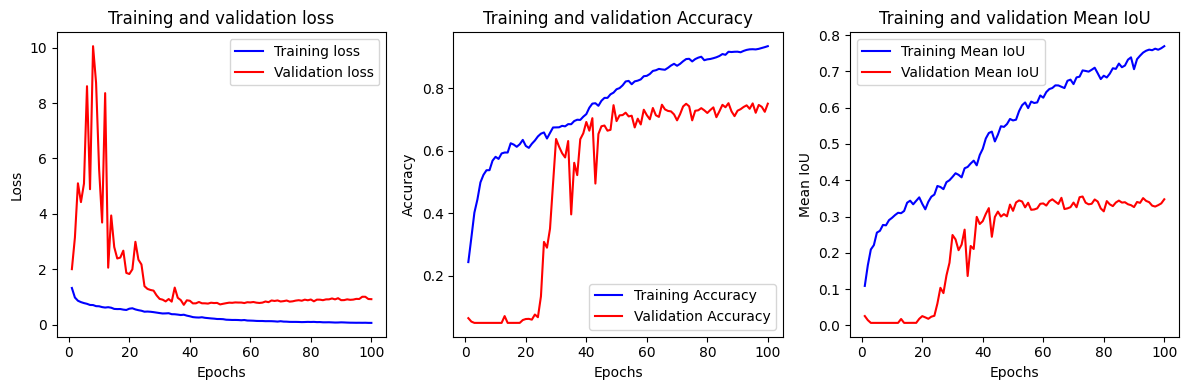

In [ ]:
# For each epoch we plot the loss, accuracy and mean iou

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

m_iou = history.history['one_hot_mean_io_u']
val_m_iou = history.history['val_one_hot_mean_io_u']

epochs = range(1, len(loss) + 1)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Loss
axs[0].plot(epochs, loss, label='Training loss', color='blue')
axs[0].plot(epochs, val_loss, label='Validation loss', color='red')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy
axs[1].plot(epochs, acc, label='Training Accuracy', color='blue')
axs[1].plot(epochs, val_acc, label='Validation Accuracy', color='red')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Mean IoU
axs[2].plot(epochs, m_iou, label='Training Mean IoU', color='blue')
axs[2].plot(epochs, val_m_iou, label='Validation Mean IoU', color='red')
axs[2].set_title('Training and validation Mean IoU')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Mean IoU')
axs[2].legend()

plt.tight_layout()
plt.show()



As we can see from the loss graph, after the first "shaky" 20 epochs, the loss starts to converge and from epoch 40 we do not feel any further improvement. We can appreciate similar results both from the Accuracy and MeanIoU graph. It is worth noticing that from epoch 40, even though the accuracy on training is still improving, on the validation we do not have any significant improvements.

## Evaluation on test set
We test the model on new data, and obtain the DICE, MeanIoU and Accuracy.

In [ ]:
# Accuracy and Mean IoU
_, m_iou, acc = model.evaluate(x_test, y_test)

print(f'Mean IoU is = {m_iou}')
print(f'Accuracy is = {acc}')


7/7 [==============================] - 2s 373ms/step - loss: 1.0812 - mean_io_u_1: 0.3745 - accuracy: 0.7475
Mean IoU is = 0.37449154257774353
Accuracy is = 0.7474926710128784


In [ ]:
# DICE
y_pred = model.predict(x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_pred_argmax_cat = to_categorical(y_pred_argmax, num_classes=N_CLASSES)

dice_coeff = dice_coef_multilabel(y_test, y_pred_argmax_cat, numLabels=N_CLASSES)

print(f'DICE: {dice_coeff}')
#print(f'y_pred_argmax: {y_pred_argmax.shape}')
#print(f'y_pred_argmax_cat: {y_pred_argmax_cat.shape}')

7/7 [==============================] - 2s 112ms/step
DICE: 0.515125162669068


## Results

DICE for single channels
(0) Unlabeled: 0.163
(1) Dense forest: 0.697
(2) Sparse forest: 0.469
(3) Moor: 0.014
(4) Herbaceous formation: 0.000
(5) Building: 0.000
(6) Road: 0.124


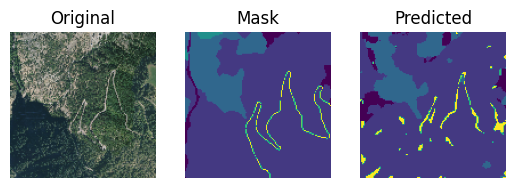

In [ ]:
# Comparisons
i = np.random.randint(N_TEST)
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Original')
plt.imshow(x_test[i])

plt.subplot(1,3,2)
plt.axis('off')
plt.title('Mask')
plt.imshow(test_masks[i], vmin=0, vmax=6)

plt.subplot(1,3,3)
plt.axis('off')
plt.title('Predicted')
plt.imshow(y_pred_argmax[i], vmin=0, vmax=6)

print(f'DICE for single channels')
for l in range(N_CLASSES):
  print(f'({l}) {labels[l]}: {dice_coef(y_test[i, :, :, l], y_pred[i, :, :, l]):.3f}')

plt.show()

In the sample above, the results are quite impressing. Even though roads are kind of cluttered and difficult to spot even to human eye, the model somehow is able to detect them. We can also appreciate how the model is able to distiguish between sparse forests and dense forests (light blue and dark blue).